In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy.matcher import PhraseMatcher
from collections import defaultdict

In [15]:
data = pd.read_json('restaurant.json')
data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
109,lDJIaF4eYRF4F7g6Zb9euw,lb0QUR5bc4O-Am4hNq9ZGg,r5PLDU-4mSbde5XekTXSCA,4,2,0,0,I used to work food service and my manager at ...,2013-01-27 17:54:54
1013,vvIzf3pr8lTqE_AOsxmgaA,MAmijW4ooUzujkufYYLMeQ,r5PLDU-4mSbde5XekTXSCA,4,0,0,0,We have been trying Eggplant sandwiches all ov...,2015-04-15 04:50:56
1204,UF-JqzMczZ8vvp_4tPK3bQ,slfi6gf_qEYTXy90Sw93sg,r5PLDU-4mSbde5XekTXSCA,5,1,0,0,Amazing Steak and Cheese... Better than any Ph...,2011-03-20 00:57:45
1251,geUJGrKhXynxDC2uvERsLw,N_-UepOzAsuDQwOUtfRFGw,r5PLDU-4mSbde5XekTXSCA,1,0,0,0,Although I have been going to DeFalco's for ye...,2018-07-17 01:48:23
1354,aPctXPeZW3kDq36TRm-CqA,139hD7gkZVzSvSzDPwhNNw,r5PLDU-4mSbde5XekTXSCA,2,0,0,0,"Highs: Ambience, value, pizza and deserts. Thi...",2018-01-21 10:52:58


In [16]:
menu = ["Cheese Steak", "Cheesesteak", "Steak and Cheese", "Italian Combo", "Tiramisu", "Cannoli",
        "Chicken Salad", "Chicken Spinach Salad", "Meatball", "Pizza", "Pizzas", "Spaghetti",
        "Bruchetta", "Eggplant", "Italian Beef", "Purista", "Pasta", "Calzones",  "Calzone",
        "Italian Sausage", "Chicken Cutlet", "Chicken Parm", "Chicken Parmesan", "Gnocchi",
        "Chicken Pesto", "Turkey Sandwich", "Turkey Breast", "Ziti", "Portobello", "Reuben",
        "Mozzarella Caprese",  "Corned Beef", "Garlic Bread", "Pastrami", "Roast Beef",
        "Tuna Salad", "Lasagna", "Artichoke Salad", "Fettuccini Alfredo", "Chicken Parmigiana",
        "Grilled Veggie", "Grilled Veggies", "Grilled Vegetable", "Mac and Cheese", "Macaroni",  
         "Prosciutto", "Salami"]

# Find the items in one review

In [17]:
# lets take review with index 14
index_of_review = 14
text_to_test = data.text.iloc[index_of_review]
print(text_to_test)

The Il Purista sandwich has become a staple of my life. Mozzarella, basil, prosciutto, roasted red peppers and balsamic vinaigrette blend into a front runner for the best sandwich in the valley. Goes great with sparkling water or a beer. 

DeFalco's also has other Italian fare such as a delicious meatball sub and classic pastas.


In [18]:
# load the spacy nlp model and find the matching items

nlp = spacy.blank('en') #loading the spacy model
review_doc = nlp(text_to_test) # creates tokenized version of the review
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')
menu_token_list = [nlp(item) for item in menu]
matcher.add('menu',menu_token_list) # add the menu patters to matcher
matches = matcher(review_doc)

In [19]:
print('Matching items for review 14 are :')
for match in matches:
    print(review_doc[match[1]:match[2]])

Matching items for review 14 are :
Purista
prosciutto
meatball


# Iterate the same for all the reviews

In [20]:
item_ratings = defaultdict(list)

for idx, review in data.iterrows():
    doc = nlp(review.text)
    matches = matcher(doc)

    found_items = set(doc[match[1]:match[2]].text.lower() for match in matches)

    for item in found_items :
        item_ratings[item].append(review.stars)


In [21]:
mean_ratings  = {item : sum(ratings)/len(ratings) for item,ratings in item_ratings.items()} 
worst_item = sorted(mean_ratings, key=mean_ratings.get)[0]

In [22]:
print(worst_item)
print(mean_ratings[worst_item])

chicken cutlet
3.4


In [23]:
# counts of the ratings
rating_detail = {item :{ 'rating_count' : len(ratings),
                         'mean_ratings' : sum(ratings)/len(ratings) 
                      }
                         for item,ratings in item_ratings.items()
                }

Text(0.5, 1.0, 'Distribution of Rating counts of all items')

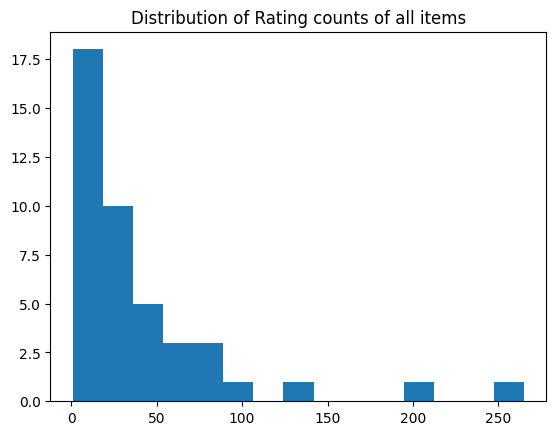

In [24]:
# distribution of review count
all_rating_counts = []
for item in rating_detail :
    all_rating_counts.append(rating_detail[item]['rating_count'])
#all_rating_counts.hist()

plt.hist(all_rating_counts, bins=15)
plt.title('Distribution of Rating counts of all items')

In [25]:
#Best and worst 10 items with review count more than 5
filtered_items = {
    item : {'count' : detail['rating_count'], 'mean' : detail['mean_ratings']}
    for item, detail in rating_detail.items()
    if detail['rating_count']>5
}

sorted_items = dict(sorted(filtered_items.items(), key = lambda x:x[1]['mean'], reverse=True))

print('Top 10 ietms based on rating')
print(f"{'Item':<20} {'Count':^10} {'Avg Rating':^10}")
print("="*40)
for item, details in list(sorted_items.items())[:10]:  # Convert to a list and slice
    print(f"{item:<20} {details['count']:^10} {details['mean']:^10.2f}")

print('')
print('')
print('Worst 10 ietms based on rating')
print(f"{'Item':<20} {'Count':^10} {'Avg Rating':^10}")
print("="*40)
for item, details in list(sorted_items.items())[-10:]:  # Convert to a list and slice
    print(f"{item:<20} {details['count']:^10} {details['mean']:^10.2f}")

Top 10 ietms based on rating
Item                   Count    Avg Rating
fettuccini alfredo       6         5.00   
steak and cheese         9         4.89   
prosciutto               50        4.68   
purista                  63        4.67   
chicken pesto            27        4.56   
calzones                 35        4.54   
grilled veggie           6         4.50   
portobello               14        4.50   
gnocchi                  37        4.49   
cheesesteak              97        4.48   


Worst 10 ietms based on rating
Item                   Count    Avg Rating
tiramisu                 21        4.24   
chicken parm             50        4.22   
meatball                128        4.18   
eggplant                 69        4.16   
roast beef               7         4.14   
garlic bread             39        4.13   
italian combo            21        4.05   
italian beef             25        3.92   
spaghetti                36        3.89   
chicken cutlet           10        

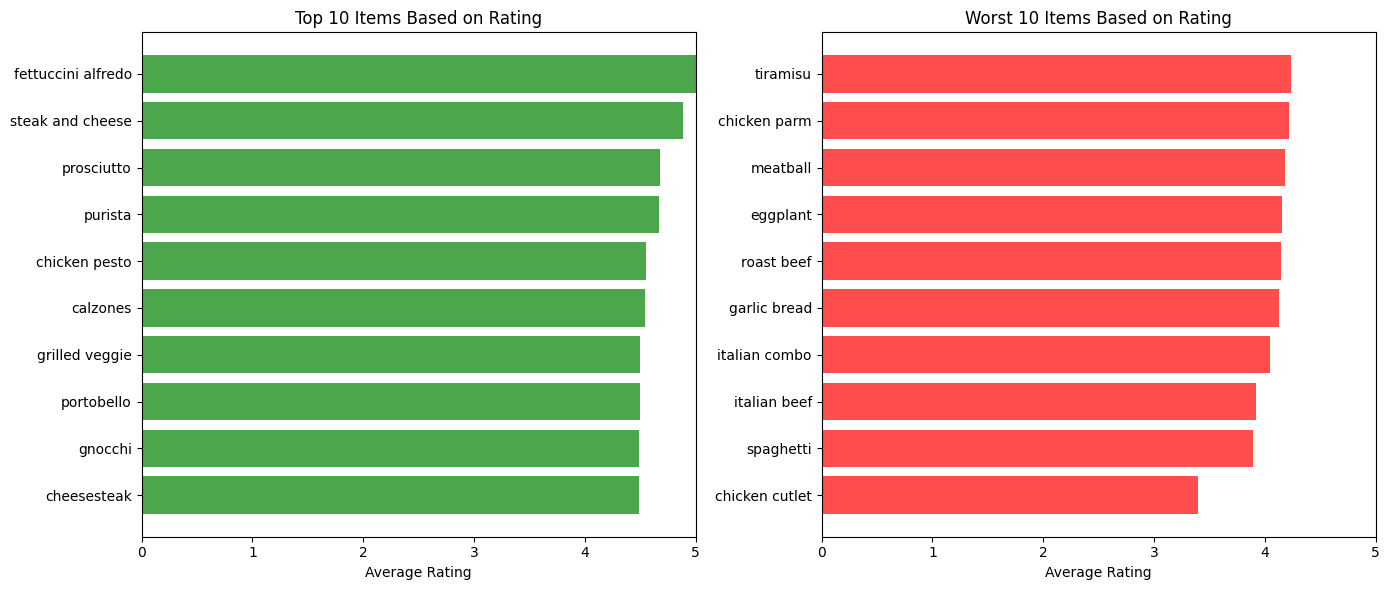

In [28]:
import matplotlib.pyplot as plt

# Extract the top 10 and worst 10 items based on rating
top_10_items = list(sorted_items.items())[:10]
worst_10_items = list(sorted_items.items())[-10:]

# Prepare data for plotting
top_items_names = [item[0] for item in top_10_items]
top_items_ratings = [item[1]['mean'] for item in top_10_items]
top_items_counts = [item[1]['count'] for item in top_10_items]

worst_items_names = [item[0] for item in worst_10_items]
worst_items_ratings = [item[1]['mean'] for item in worst_10_items]
worst_items_counts = [item[1]['count'] for item in worst_10_items]

# Plotting the top 10 items
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(top_items_names, top_items_ratings, color='green', alpha=0.7)
plt.xlabel("Average Rating")
plt.xlim(0,5)
plt.title("Top 10 Items Based on Rating")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Plotting the worst 10 items
plt.subplot(1, 2, 2)
plt.barh(worst_items_names, worst_items_ratings, color='red', alpha=0.7)
plt.xlabel("Average Rating")
plt.xlim(0,5)
plt.title("Worst 10 Items Based on Rating")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()